## Label prediction with Cars dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Getting the data

In [3]:
path = 'dataset'

In [4]:
!pwd

/home/jupyter/cars_classification


## Classification

In [5]:
df = pd.read_csv(os.path.join(path, 'df_train.csv'))
df.head()

,fname,class
0,00001.jpg,14
1,00002.jpg,3
2,00003.jpg,91
3,00004.jpg,134
4,00005.jpg,106


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [6]:
tfms = get_transforms(flip_vert=False, max_lighting=0.2, max_zoom=1.1, max_warp=0.2)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'df_train.csv', folder='cars_train', suffix='')
       .split_by_rand_pct(0.2)
       .label_from_df())

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

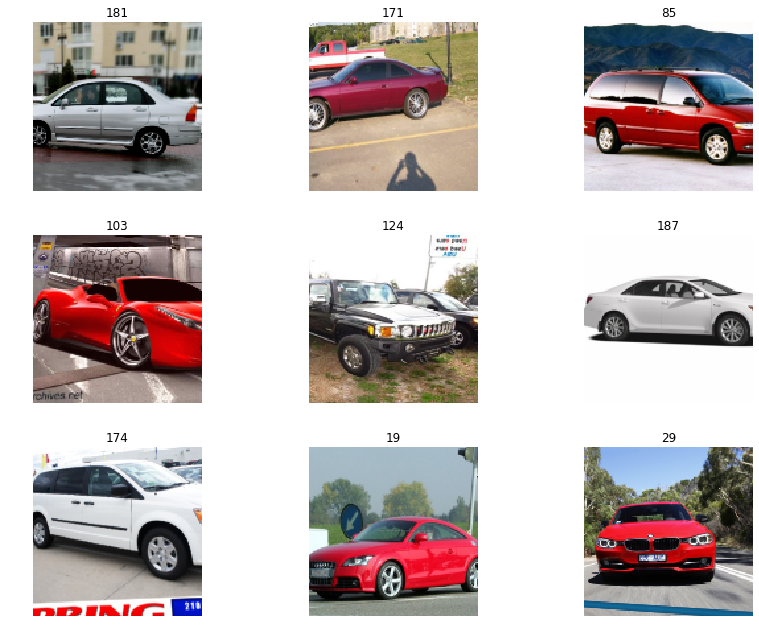

In [9]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [10]:
arch = models.resnet152

In [11]:
len(data.classes),data.c

(196, 196)

In [12]:
learn = cnn_learner(data, arch, metrics=accuracy)

We use the LR Finder to pick a good learning rate.

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


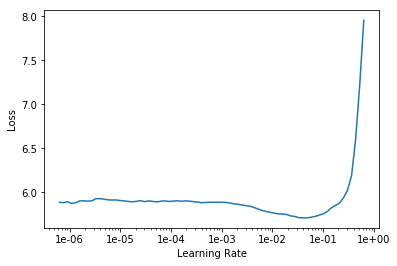

In [14]:
learn.recorder.plot()

Then we can fit the head of our network.

In [15]:
lr = 0.01 * 2

In [ ]:
learn.fit_one_cycle(35, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,5.132072,4.392569,0.098894,00:58
1,4.234251,3.639213,0.187346,00:58
2,3.570994,3.049134,0.268428,00:58
3,3.126902,2.716139,0.331081,00:59
4,2.888447,2.568676,0.350123,00:58
5,2.669358,2.462751,0.382678,00:58
6,2.482311,2.309017,0.401106,00:58


In [ ]:
learn.save('stage-1-rn152')

### Tuning all the layers of the model now

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(25, slice(1e-5, lr/5))

In [ ]:
learn.save('stage-2-rn152')

### Training with bigger size

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch(bs=16).normalize(imagenet_stats))

learn.data = data
learn.data.batch_size = 16
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(15, slice(lr))

In [ ]:
learn.save('stage-1-256-rn152')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(15, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn152')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## Validation

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)